<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Week 10 Homework
Due: March 19, 2025

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import scipy.stats as stats
import sklearn
import time

## Q1: Bayesian Logistic Regression

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### Preparing the data

Binary outcome Wisconsin breast cancer dataset from sklearn.
Target variable y=1 if the mass is cancerous, 0 if it is not cancerous

In [16]:
# Wisconsin breast cancer dataset from sklearn
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
# print the head of the data
X = data.data # (n, p) data matrix
y = data.target # (n, 1) target vector
# p = X.shape[1] # number of features # X will be reduced so calculate this later
# pd.DataFrame(X, columns=data.feature_names).head() # print the first few rows of X before normalization
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [9]:
# find features to remove to prevent overfitting the data
X_df = pd.DataFrame(X, columns=data.feature_names)
feature_names = data.feature_names
corr_matrix = X_df.corr()
high_corr = np.where(np.abs(corr_matrix) > 0.8)
high_corr_pairs = [(feature_names[i], feature_names[j])
                   for i, j in zip(*high_corr) if i != j and i < j]

print("Highly Correlated Pairs:")
print(high_corr_pairs)

Highly Correlated Pairs:
[(np.str_('mean radius'), np.str_('mean perimeter')), (np.str_('mean radius'), np.str_('mean area')), (np.str_('mean radius'), np.str_('mean concave points')), (np.str_('mean radius'), np.str_('worst radius')), (np.str_('mean radius'), np.str_('worst perimeter')), (np.str_('mean radius'), np.str_('worst area')), (np.str_('mean texture'), np.str_('worst texture')), (np.str_('mean perimeter'), np.str_('mean area')), (np.str_('mean perimeter'), np.str_('mean concave points')), (np.str_('mean perimeter'), np.str_('worst radius')), (np.str_('mean perimeter'), np.str_('worst perimeter')), (np.str_('mean perimeter'), np.str_('worst area')), (np.str_('mean area'), np.str_('mean concave points')), (np.str_('mean area'), np.str_('area error')), (np.str_('mean area'), np.str_('worst radius')), (np.str_('mean area'), np.str_('worst perimeter')), (np.str_('mean area'), np.str_('worst area')), (np.str_('mean smoothness'), np.str_('worst smoothness')), (np.str_('mean compactn

In [20]:
# remove features that are highly correlated to another feature
# this reduces model complexity, makes sure only features that are actually relevant are included
# and helps prevent overfitting
# I was getting this warning before reducing the number of features
# ERROR:pymc.stats.convergence:There were 68 divergences after tuning. Increase target_accept or reparameterize.
remove_features = [
    'mean perimeter', 'mean area', 'mean concave points', 'worst radius',
    'worst perimeter', 'worst area', 'worst texture', 'area error',
    'worst smoothness', 'mean concavity', 'worst compactness',
    'worst concavity', 'worst concave points', 'perimeter error',
    'compactness error', 'worst fractal dimension'
]
X_reduced = X_df.drop(columns=remove_features).values
p = X_reduced.shape[1]
# type(X_reduced) == type(X) # debugging

#### Bayesian Logistic Regression in PyMC

In [25]:
with pm.Model() as BayesianLogisticRegression:
  beta0 = pm.Normal('beta0', mu=0, sigma=1)
  betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
  logits = beta0 + X_reduced @ betas
  p_hat = pm.math.sigmoid(logits)
  y_obs = pm.Bernoulli('y_obs', p=p_hat, observed=y)
  idata1 = pm.sample(4000, tune=2000, return_inferencedata=True, target_accept=0.95)

Output()

#### Inference with Bayesian Posterior Analysis & MCMC Diagnostics

In [26]:
# Bayesian inference
az.summary(idata1, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.94543,0.27713,0.42252,1.45495,0.00342,0.00251,6636.20104,5995.21625,1.00036
betas[0],-2.86937,0.55375,-3.88401,-1.79551,0.00673,0.00479,6771.95579,5635.67326,1.00062
betas[1],-1.41648,0.29281,-2.00159,-0.90710,0.00369,0.00265,6330.03019,6137.73365,1.00014
betas[2],-1.02467,0.39549,-1.78753,-0.30642,0.00495,0.00357,6390.37959,5658.38251,0.99987
betas[3],-0.93171,0.54313,-1.91124,0.11112,0.00679,0.00500,6423.14129,5878.28170,1.00059
betas[4],0.47090,0.38700,-0.23579,1.20997,0.00451,0.00341,7391.01841,5913.60598,1.00025
betas[5],0.52924,0.52615,-0.50654,1.49469,0.00688,0.00546,5866.56374,5220.74302,1.00028
betas[6],-2.23813,0.54668,-3.28043,-1.22523,0.00660,0.00478,6905.59511,5618.84512,1.00016
betas[7],0.05384,0.32781,-0.58001,0.66518,0.00400,0.00342,6732.83175,6022.67856,1.00025
betas[8],-0.25673,0.36289,-0.94052,0.41607,0.00403,0.00341,8127.97813,6194.17515,1.00034


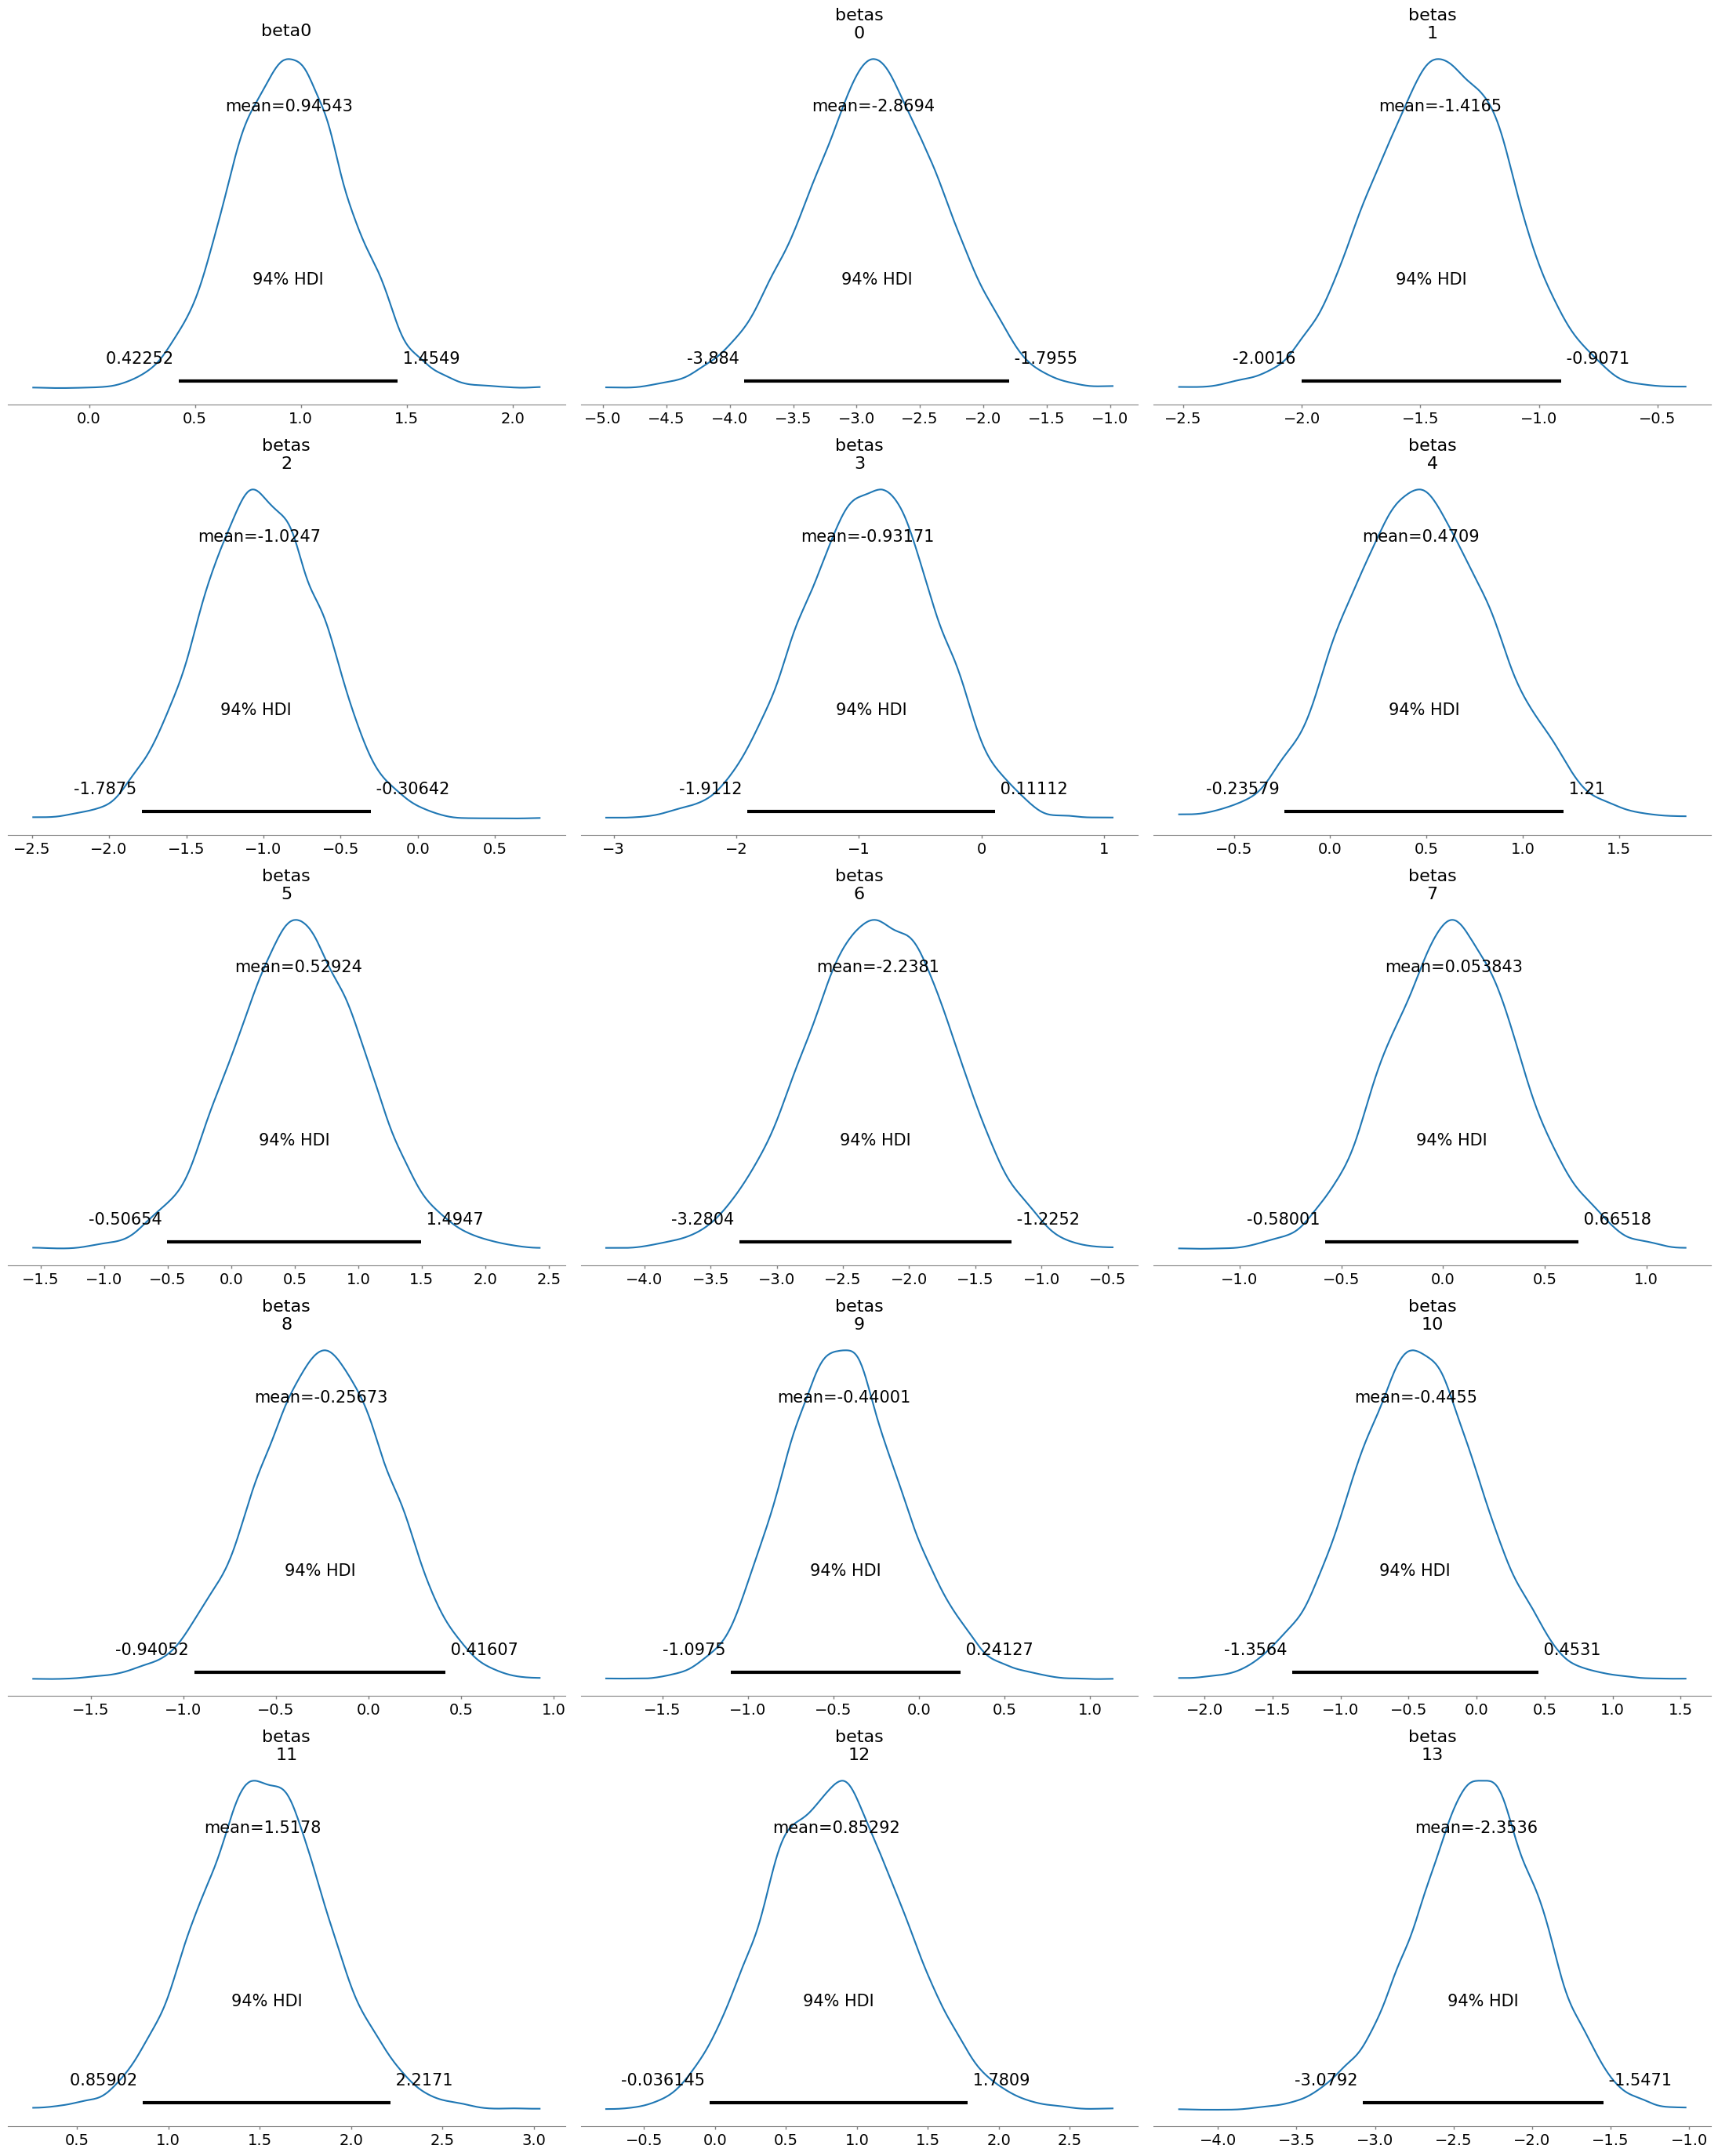

In [30]:
# Visualizing the posterior
az.plot_posterior(idata1, var_names = ["beta0", "betas"], round_to=5)
plt.tight_layout()
plt.show()

Output()

<ipython-input-31-60e8a2ca498a>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


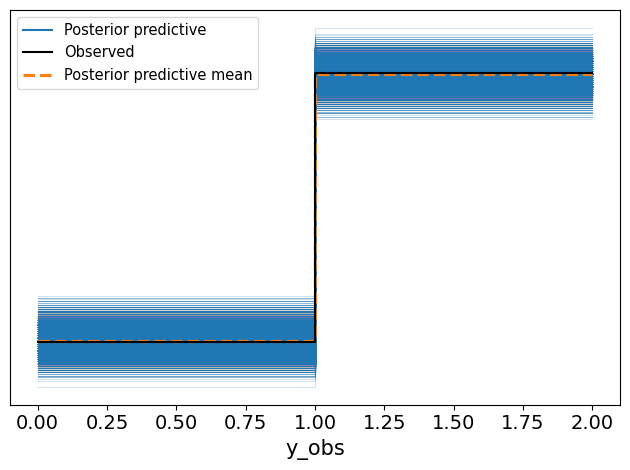

In [31]:
# Posterior Predictive Checks

# generate posterior predictive samples
with BayesianLogisticRegression:
    posterior_predictive = pm.sample_posterior_predictive(idata1)

# gdd posterior predictive samples to the inference data
idata1.extend(posterior_predictive)

# plot posterior predictives
az.plot_ppc(idata1)
plt.tight_layout()
plt.show()

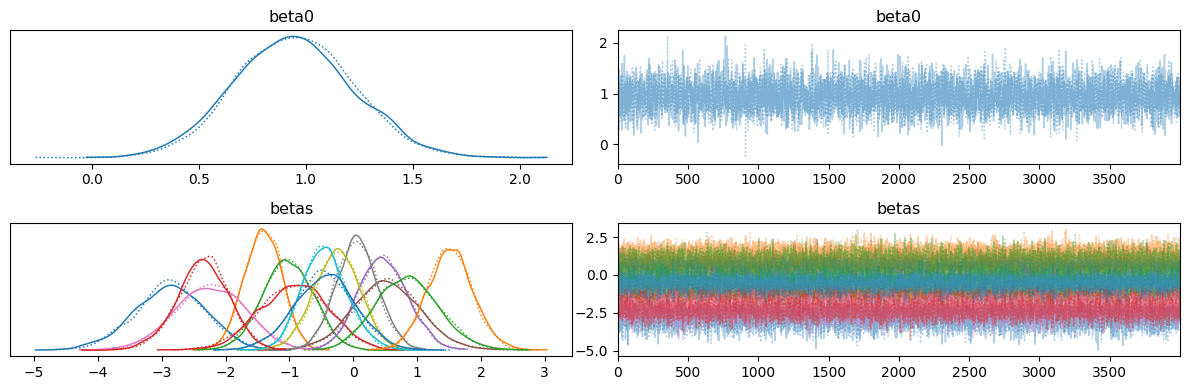

In [27]:
az.plot_trace(idata1)
plt.tight_layout()
plt.show()

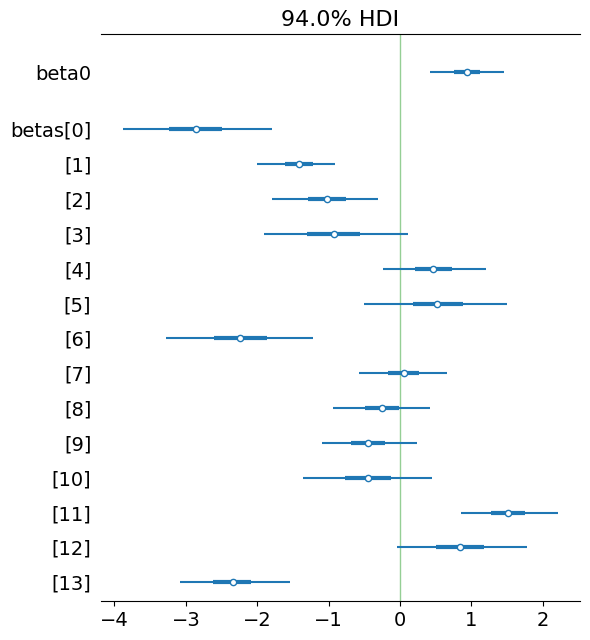

In [28]:
az.plot_forest(idata1, combined=True, rope = (0,0))
plt.tight_layout()
plt.show()

## Q2: Bayesian Multivariate Regression
- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### sklearn wine dataset

n=178 observations
so this is a reasonably small dataset

i can choose multiple continuos outcomes from this. chatGPT recommended this dataset for bayesian multivariate regression.

In [3]:
# import the wine dataset from sklearn
wine_dataset = sklearn.datasets.load_wine()

# see the first few rows of the dataaset
wine_dataset = pd.DataFrame(wine_dataset.data, columns=wine_dataset.feature_names)
wine_dataset.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


#### Bayesian multivariate regression and inference with posterior & mcmc diagnostics
Using the full dataset n=178
outcome variables: alcohol and malic_acid
predictors: ash, magnesium, flavinoids, color_intensity, hue

so this is using m=2, p=5, n=178

if the number of features (p) is too large (i.e. i include features that are highly correlated to one anther, pymc will give a warning and the model may overfit)

Given the relatively small size of the data, if the number of continuos outcomes i am modeling (m) and the number of featues (p) get too large, the model may be too complex & overfit

In [5]:
# prepare the data

features = ['ash', 'magnesium', 'flavanoids', 'color_intensity', 'hue'] # multiple features
outcomes = ['alcohol', 'malic_acid'] # multiple continuous outcpmes

X = wine_dataset[features].values # (n, p) matrix
Y = wine_dataset[outcomes].values # (n, m) matrix

# normalize
X = (X - X.mean(axis=0))/X.std(axis=0)
Y = (Y - Y.mean(axis=0))/Y.std(axis=0)

n, p = X.shape
m = Y.shape[1]


In [6]:
# beta_ = np.ones((p,m))
# X = stats.norm().rvs((n,p))
a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
# x = X@beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

with pm.Model() as MNV_LKJ:

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)

    L = pm.expand_packed_triangular(m, packed_L)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))

    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    Y_obs = pm.MvNormal('Y',
                        mu = X @ betas,
                        chol=L,  #cov=Sigma
                        observed=Y)

    idata2 = pm.sample(draws=5000,
                       tune=2000,
                       random_seed=123,
                       return_inferencedata=True,
                       target_accept=0.95,
                       chains=4)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

In [25]:
vars2 = ["betas", "Sigma"]

In [26]:
az.summary(idata2, var_names=vars2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.00121,0.06227,-0.11654,0.11713,0.00038,0.00043,26245.00260,15913.57794,1.00007
"betas[0, 1]",0.17448,0.06637,0.04823,0.29835,0.00042,0.00032,24628.62344,15135.65249,1.00007
"betas[1, 0]",0.08593,0.06295,-0.03264,0.20413,0.00039,0.00032,26003.11063,15794.17984,1.00011
"betas[1, 1]",-0.02847,0.06642,-0.15655,0.09289,0.00040,0.00043,27365.58545,15900.57652,1.00023
"betas[2, 0]",0.27029,0.07194,0.13400,0.40513,0.00047,0.00034,23377.86256,16047.06107,1.00006
"betas[2, 1]",-0.17030,0.07511,-0.31184,-0.02790,0.00051,0.00037,21768.51953,15410.35479,1.00018
"betas[3, 0]",0.62786,0.07175,0.49523,0.76452,0.00050,0.00035,20828.34237,14964.32483,1.00019
"betas[3, 1]",-0.07747,0.07685,-0.22721,0.06370,0.00051,0.00042,22513.49183,15784.36929,1.00004
"betas[4, 0]",0.10409,0.08079,-0.04355,0.25771,0.00056,0.00042,20475.41011,15567.77890,1.00009
"betas[4, 1]",-0.49174,0.08515,-0.64912,-0.33074,0.00061,0.00044,19302.27502,15096.50490,1.00052


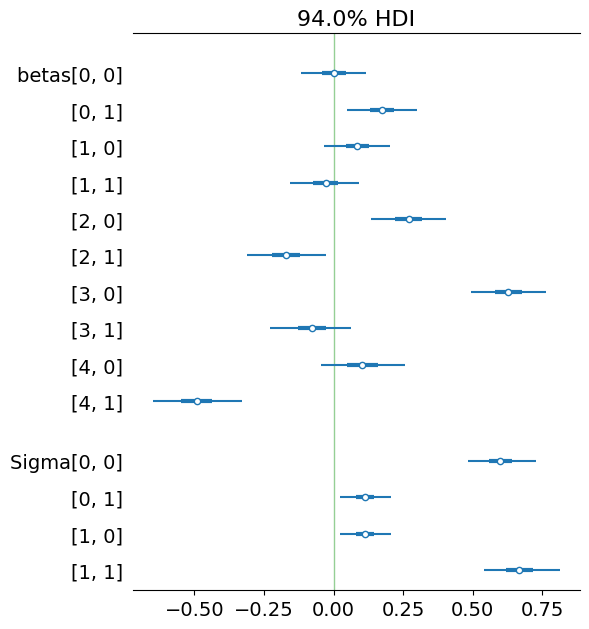

In [27]:
az.plot_forest(idata2, var_names=vars2, combined=True, rope = (0,0))
plt.tight_layout()
plt.show()

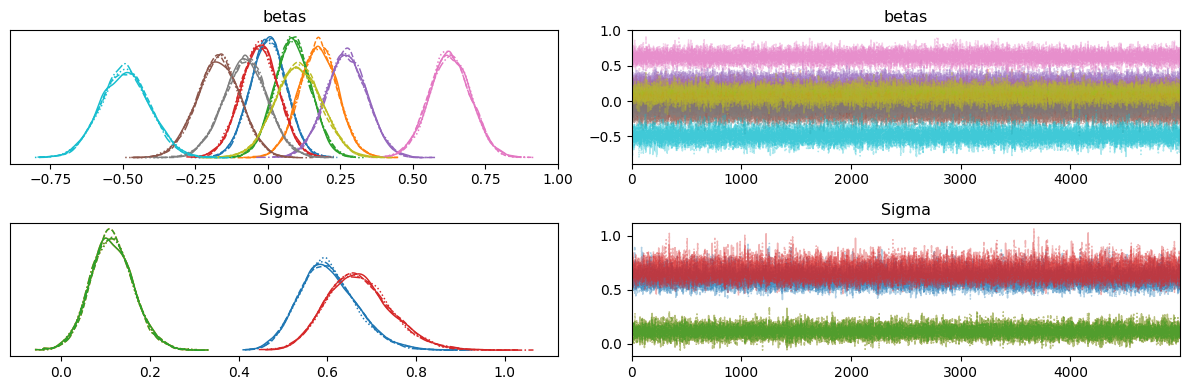

In [28]:
# trace plots
az.plot_trace(idata2,var_names=vars2)
plt.tight_layout()
plt.show()

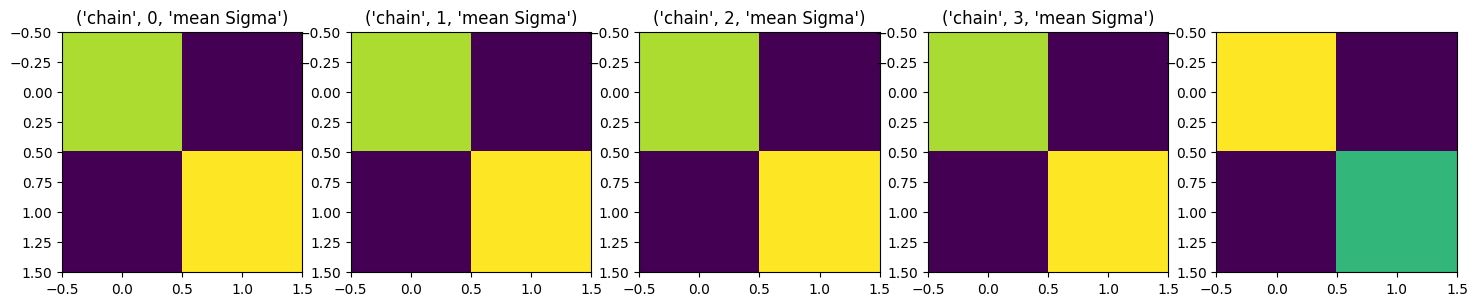

In [11]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4): # 4 chains
    ax[chain].imshow(idata2.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chain",chain,"mean Sigma"))

Output()

<ipython-input-12-80b690430958>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


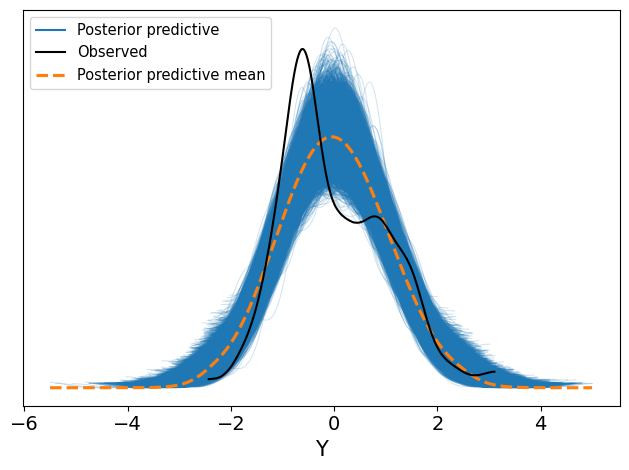

In [12]:
# Posterior Predictive Checks

# generate posterior predictive samples
with MNV_LKJ:
    posterior_predictive = pm.sample_posterior_predictive(idata2)

# add posterior predictive samples to the inference data
idata2.extend(posterior_predictive)

# plot posterior predictives
az.plot_ppc(idata2)
plt.tight_layout()
plt.show()

#### Downsample to explore the effect of different values of n, m, p
* report findings based on that
* wine dataset is "reasonably small" (n=178), so I'll peform actual analysis on it

 increasing m and p. decreasing n.

 I am going to use m=4, p=8, n=100 here

In [16]:
# features & outcomes
more_features = ['ash', 'magnesium', 'flavanoids', 'color_intensity', 'hue',
                 'total_phenols', 'alcalinity_of_ash', 'proanthocyanins'] # 8 features
more_outcomes = ['alcohol', 'malic_acid', 'od280/od315_of_diluted_wines', 'proline'] # 4 continuous outcomes instead of 2

X = wine_dataset[features].values # (n, p) matrix
Y = wine_dataset[outcomes].values # (n, m) matrix

# subset the data
# randomly choose 100 rows
# as of now n is still 178
np.random.seed(100)
indices = np.random.choice(X.shape[0], size=n//2, replace=False) # cut the dataset in half
X_downsample = X[indices]
Y_downsample = Y[indices]

In [22]:
# perform bayesian multivariate regression again
m, n, p = Y_downsample.shape[0], X_downsample.shape[0], X_downsample.shape[1]
with pm.Model() as MNV_LKJ_downsample:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)

    L = pm.expand_packed_triangular(m, packed_L)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))

    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    Y_obs = pm.MvNormal('Y',
                        mu = X_downsample @ betas,
                        chol=L,  #cov=Sigma
                        observed=Y_downsample)

    idata2_downsample = pm.sample(draws=5000,
                       tune=2000,
                       random_seed=123,
                       return_inferencedata=True,
                       target_accept=0.95,
                       chains=4)

Output()

In [19]:
# bayesian posterior inference and mcmc diagnostics
az.summary(idata2_downsample, var_names=vars2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",2.50326,0.35226,1.82397,3.15056,0.00311,0.00220,12813.31846,12931.80071,1.00012
"betas[0, 1]",1.38530,0.30242,0.81992,1.95989,0.00289,0.00205,10979.81763,12395.91124,1.00003
"betas[1, 0]",0.03256,0.00771,0.01844,0.04731,0.00006,0.00005,14432.26147,14033.64424,1.00017
"betas[1, 1]",0.01129,0.00649,-0.00101,0.02332,0.00006,0.00004,12608.25107,13430.27602,1.00009
"betas[2, 0]",0.14958,0.15920,-0.14681,0.45010,0.00120,0.00093,17476.76195,15155.03361,1.00020
"betas[2, 1]",-0.20817,0.13443,-0.45582,0.04739,0.00102,0.00074,17418.01500,15039.71939,1.00001
"betas[3, 0]",0.27057,0.06297,0.14911,0.38626,0.00053,0.00037,14282.73303,15466.09416,1.00003
"betas[3, 1]",-0.04187,0.05410,-0.14274,0.06114,0.00046,0.00033,13580.91324,14127.15305,1.00025
"betas[4, 0]",2.18747,0.53644,1.20462,3.21582,0.00464,0.00330,13364.57856,14593.69834,1.00005
"betas[4, 1]",-1.52540,0.47664,-2.43967,-0.64869,0.00415,0.00296,13181.89796,14235.99619,1.00002


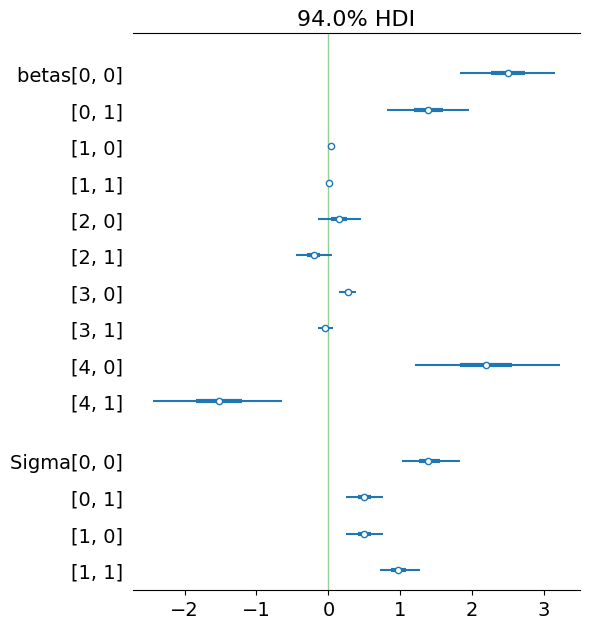

In [29]:
az.plot_forest(idata2_downsample, var_names=vars2, combined=True, rope = (0,0))
plt.tight_layout()
plt.show()

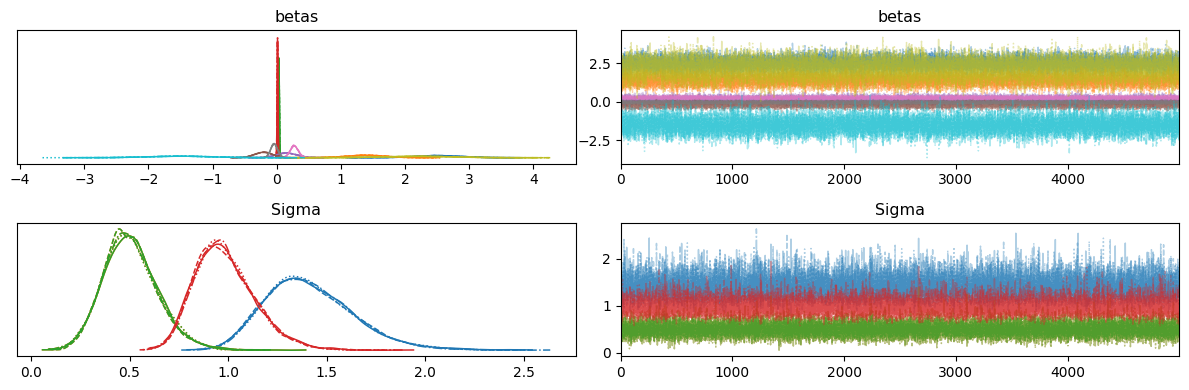

In [30]:
az.plot_trace(idata2_downsample,var_names=vars2)
plt.tight_layout()
plt.show()

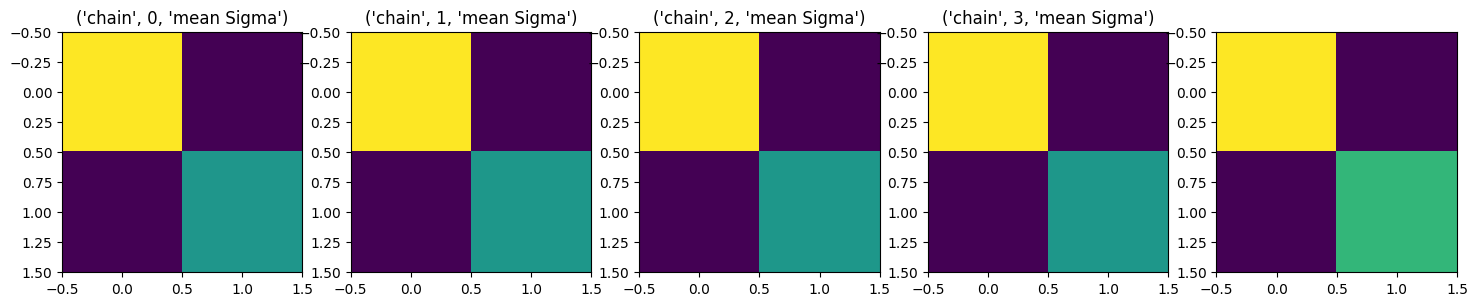

In [31]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4): # 4 chains
    ax[chain].imshow(idata2_downsample.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chain",chain,"mean Sigma"))

Output()

<ipython-input-32-3750d25427b9>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


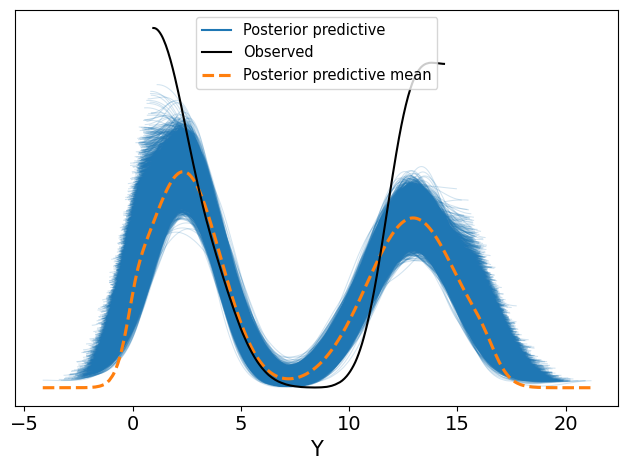

In [32]:
# Posterior Predictive Checks

# generate posterior predictive samples
with MNV_LKJ_downsample:
    posterior_predictive = pm.sample_posterior_predictive(idata2_downsample)

# add posterior predictive samples to the inference data
idata2_downsample.extend(posterior_predictive)

# plot posterior predictives
az.plot_ppc(idata2_downsample)
plt.tight_layout()
plt.show()

When I increased the number of predictors (p) and the number of outcome variables (m), and downsampled (halved n) the running time increased and some of the predictor posteriors had a bit less uncertainty, while others had wide HDIs indicationg a lot of uncertainty.
This is probably because model complexity increased (it definitely required a more complex model in this case) & over fitting is a possibility.
Posterior estimates for the betas and Sigma changed as well when m, n, p were adjusted.

Estimates change.

This demonstrates that the sample size (n), num predictors (aka features in ML)(p), and num outcome variables (m) are very important when fitting a model.

## Q3: Bayesian Multivariate Classification
- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### prepare the california housing dataset

I am using the `sklearn` California housing dataset for this question.

Predictors (Betas):


*  MedInc
* HouseAge
* AveRooms
* AveBedrooms
* Population
* AveOccup
* Latitude
* Longditude

Target (Y):
* Coast (1 if near the coast, 0 otherwise)
* HighIncome (1 if above MedInc, 0 otherwise)
* BigHouse (1 if more rooms than average)
* Old (1 if more than 75 years old, 0 otherwise)

I modified the data frame to have some binary outcome variables.

In [133]:
# load the dataset
from sklearn.datasets import fetch_california_housing
california_housing_data = fetch_california_housing(as_frame=True)
df = california_housing_data.frame
df.head()

# create some binary outcome variables
# Define the coastal region based on latitude and longitude
df['Coast'] = (
    (df['Longitude'] >= -124.5) & (df['Longitude'] <= -117) &  # Coastal longitudes
    (df['Latitude'] >= 32.5) & (df['Latitude'] <= 42)          # California latitude range
).astype(int)

high_income_threshold = df['MedInc'].quantile(0.75)
df['HighIncome'] = (df['MedInc'] > high_income_threshold).astype(int)

# BigHouse: 1 if more rooms than 75th percentile, 0 otherwise
big_house_threshold = df['AveRooms'].quantile(0.75)
df['BigHouse'] = (df['AveRooms'] > big_house_threshold).astype(int)

# Old: 1 if house age > 75 years, 0 otherwise
df['Old'] = (df['HouseAge'] > 75).astype(int)

# drop nas
df = df.dropna()

# print a few rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Coast,HighIncome,BigHouse,Old
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1,1,1,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1,1,1,0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1,1,1,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1,1,0,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1,0,1,0


In [71]:
# how big is the dataset currently?
# make it "reasonably small" to decrease running time later on in the question!!!!
# how many observations lmao
df.shape
# 20,640 observations is not reasonably small and will take forever to work with

(20640, 13)

#### downsample & provide inference

In [134]:
# set up for downsampling
x1 = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'
    ]
x2 = ['MedInc', 'Population', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms']
x3 = ['MedInc', 'Latitude', 'Longitude']


y1 = ['Coast', 'HighIncome', 'BigHouse', 'Old']
y2 = ['Coast', 'Old', 'BigHouse']
y3 = ['Coast', 'HighIncome']

n_values = [500, 250, 100, 50] # going to make the data "reasonably small" to perform my analysis
m_values = [y1, y2, y3]
p_values = [x1, x2, x3]

In [128]:
def fit_bayesian_multivariate_classification(df, n, features, outcomes, draws=500, tune=200):
  """
  Perform Bayesian Multivariate Classification using PyMC3.
  using target_accept=0.95 and 4 chains
  """
  # set up X and Y
  df_ = df.copy() # make a copy of the data
  df_ = df_.sample(n=n, random_state=123)
  X = df_[features].values # n x p matrix
  Y = df_[outcomes].values # n x m matrix
  n, p = X.shape
  m = Y.shape[1]

  # normalize the data
  scaler = sklearn.preprocessing.StandardScaler()
  X = scaler.fit_transform(X)
  Y = scaler.fit_transform(Y)
  Y = np.clip(Y, 1e-6, 1 - 1e-6)

  # actually do the modeling with pymc
  start = time.time()
  with pm.Model() as GLM:
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                sd_dist=pm.Exponential.dist(1.0, shape=m),
                                compute_corr=True)
    # packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
    #                              sd_dist=pm.Exponential.dist(1.0, shape=m),
    #                              compute_corr=False)
    # L = pm.expand_packed_triangular(m, packed_L)
    # packed_L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=m), compute_corr=True)
    # L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    z = pm.MvNormal('z', mu=X@betas, chol=L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    # Y_obs = pm.Bernoulli('Y_obs', p=pm.math.invprobit(z), observed=Y)
    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.clip(pm.math.invprobit(z), 1e-6, 1 - 1e-6), observed=Y)
    idata = pm.sample(draws=draws, tune=tune, return_inferencedata=True, target_accept=0.95, chains=1)
  return idata, time.time()-start, GLM

In [129]:
X_ca = df[x1].values
Y_ca = df[y1].values
n = X_ca.shape[0]
idata, time_taken, GLM = fit_bayesian_multivariate_classification(df, n, x1, y1)

Output()

Bayesian posterior analysis & MCMC diagnostics for n=500, p=8, m=4


Output()

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


running time: 641.0389885902405 seconds


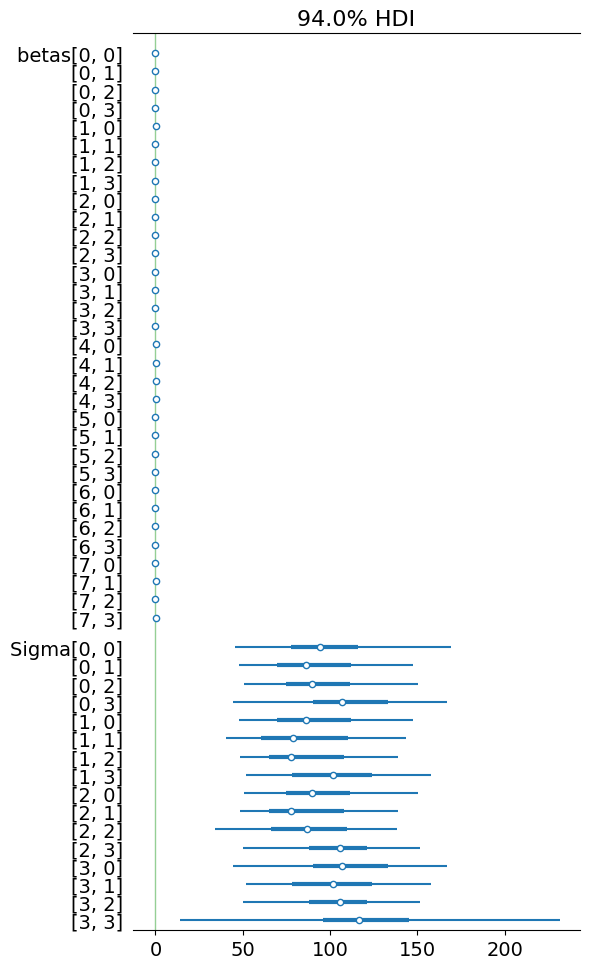

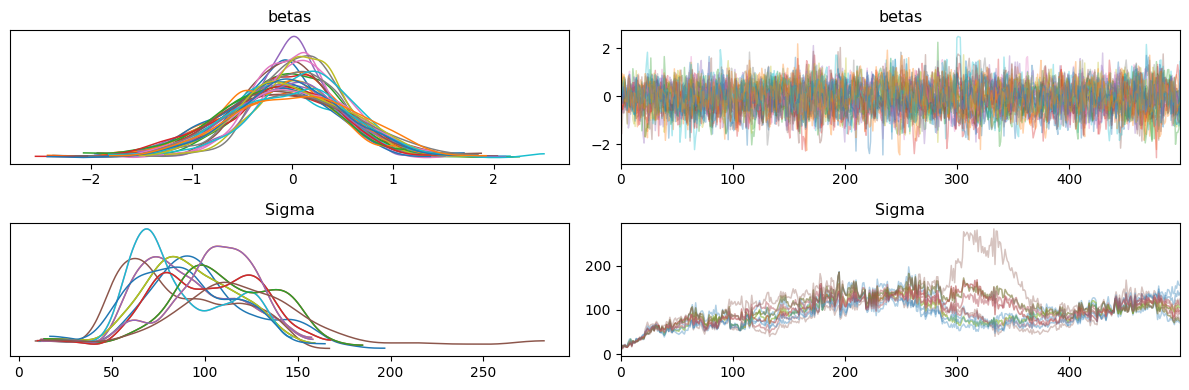

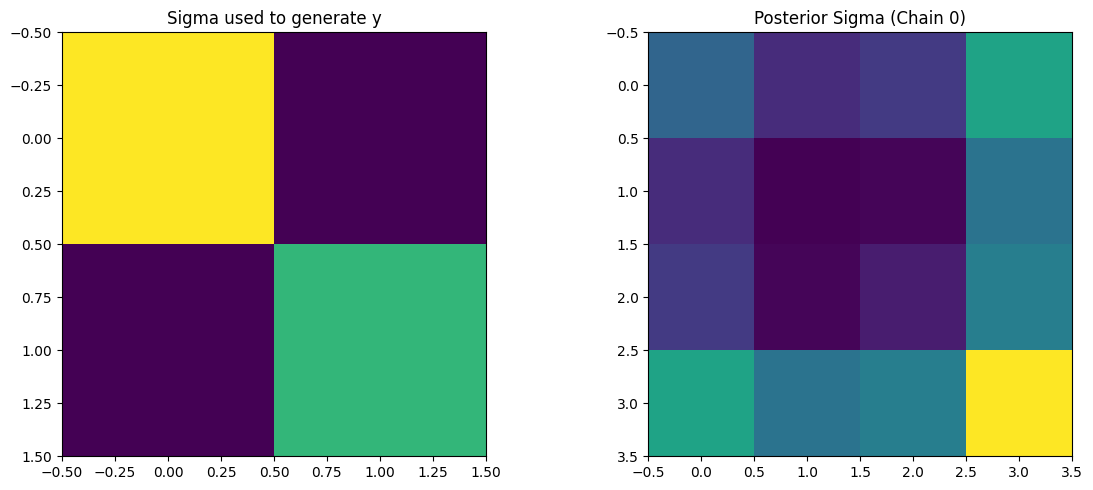

Output()

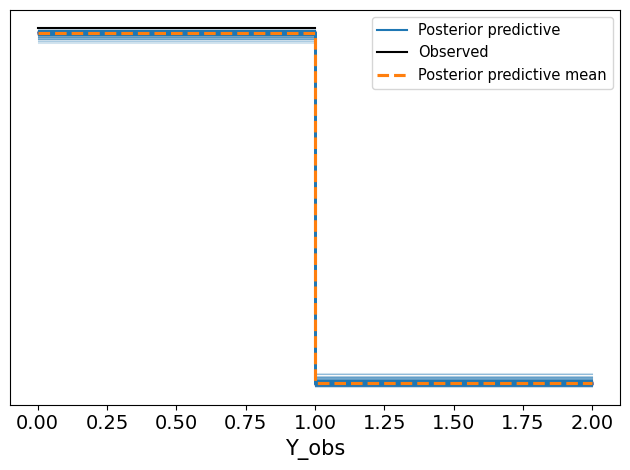

Bayesian posterior analysis & MCMC diagnostics for n=500, p=8, m=3


Output()

ERROR:pymc.stats.convergence:There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


running time: 571.6292607784271 seconds


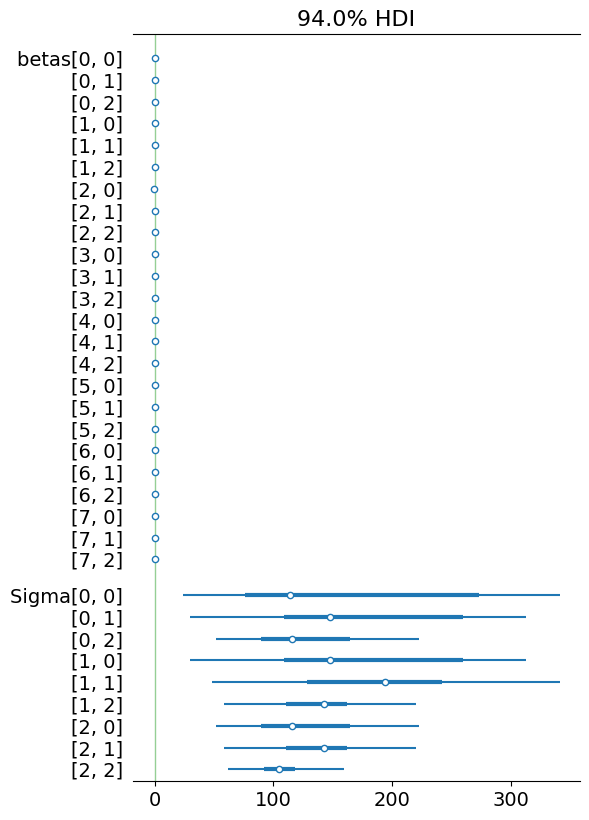

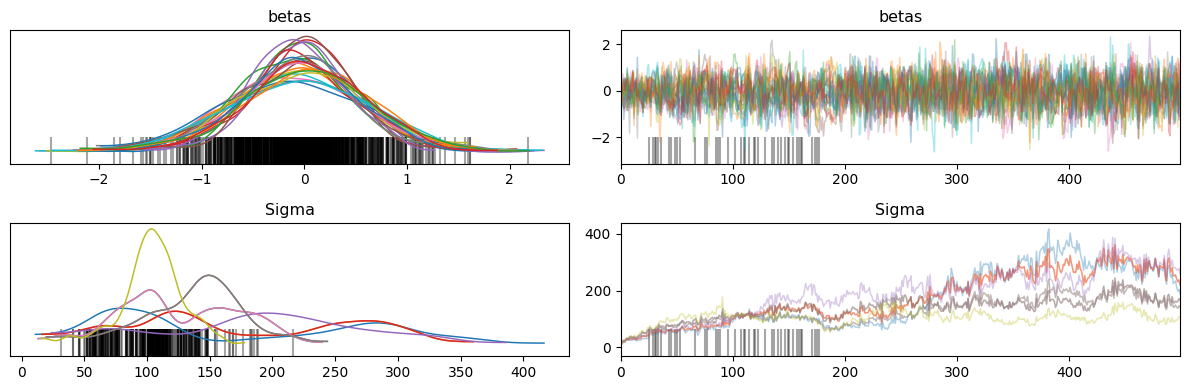

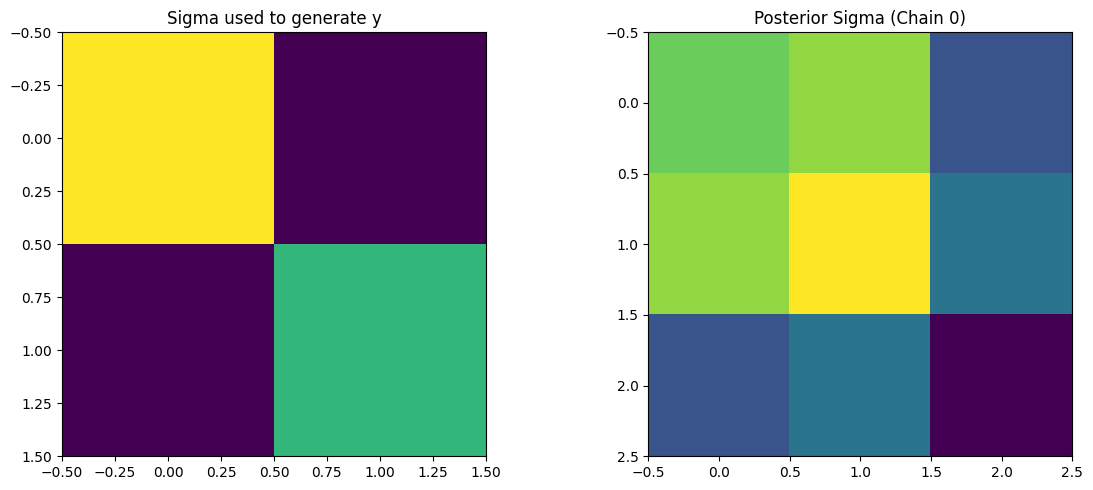

Output()

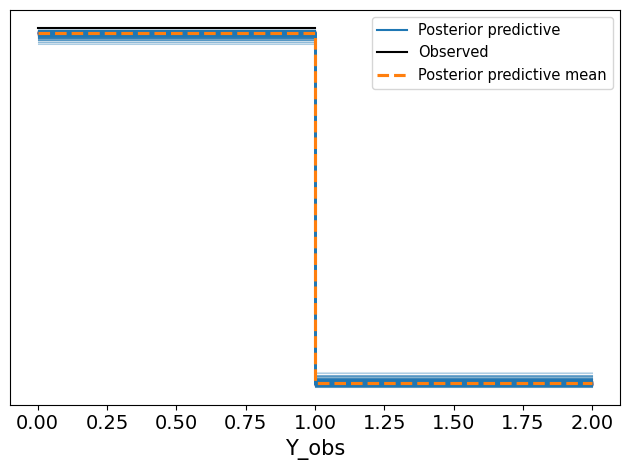

Bayesian posterior analysis & MCMC diagnostics for n=500, p=8, m=2


Output()

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


running time: 533.9665076732635 seconds


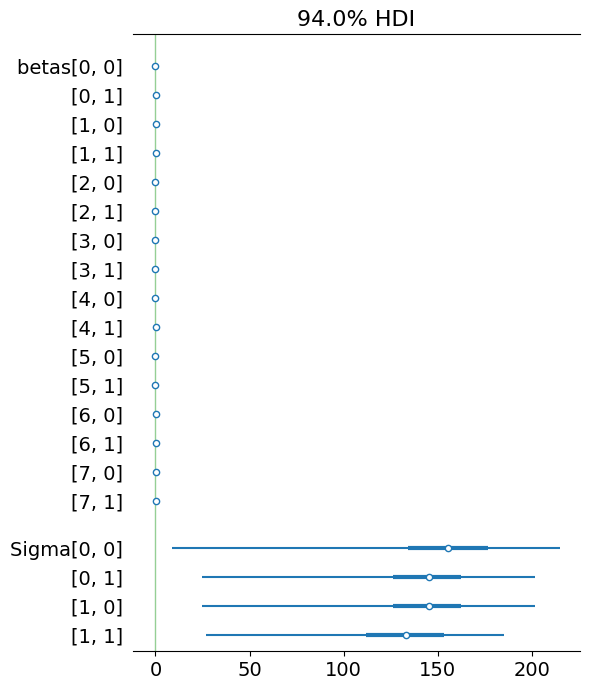

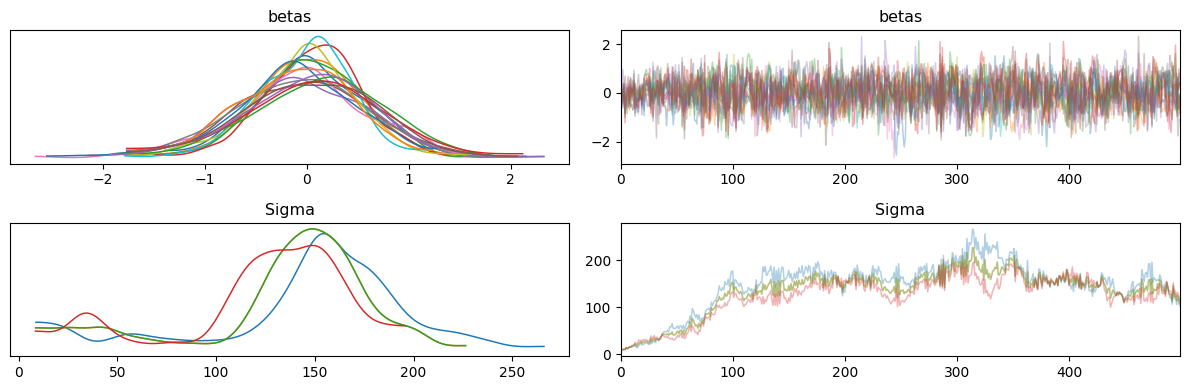

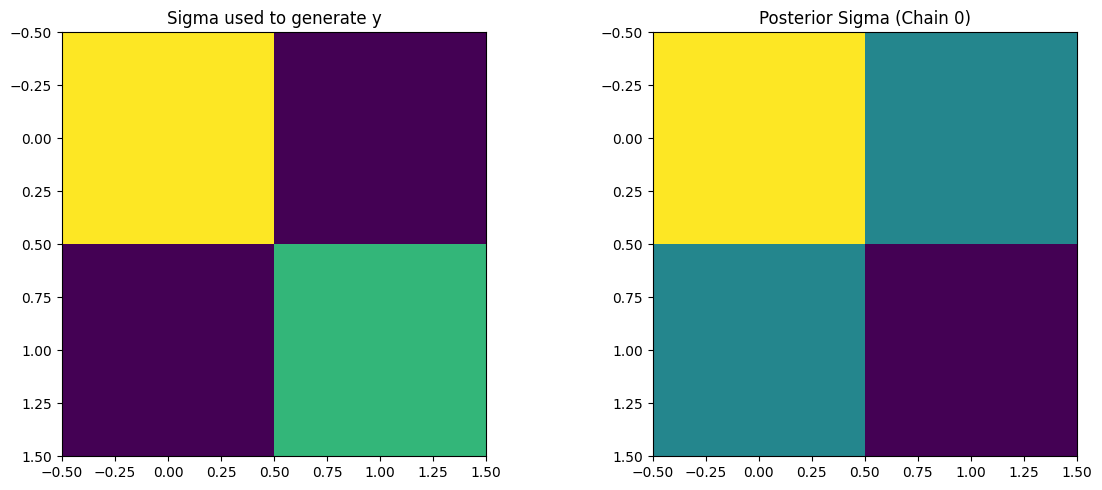

Output()

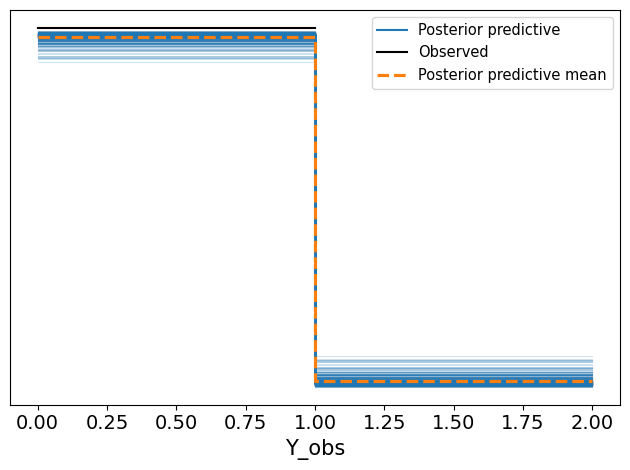

Bayesian posterior analysis & MCMC diagnostics for n=500, p=6, m=4


KeyError: "['Longditude'] not in index"

In [131]:
for n_ in n_values:
  for features in p_values:
    for outcomes in m_values:

      print(f"Bayesian posterior analysis & MCMC diagnostics for n={n_}, p={len(features)}, m={len(outcomes)}")
      idata, running_time, GLM = fit_bayesian_multivariate_classification(df, n_, features, outcomes)
      print(f"running time: {running_time} seconds")

      # perform bayesian inference

      # Summary
      az.summary(idata, var_names=["betas", "Sigma"], round_to=2)

      # Forest plot
      az.plot_forest(idata, var_names=["betas", "Sigma"], combined=True, rope = (0,0))
      plt.tight_layout()
      plt.show()

      # Trace Plot
      az.plot_trace(idata,var_names=["betas", "Sigma"])
      plt.tight_layout()
      plt.show()

      # Covariance matrix
      fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Use 2 subplots: one for the true Sigma, one for the chain
      ax[0].imshow(a_cov)
      ax[0].set_title("Sigma used to generate y")

      # Plot the posterior Sigma for chain 0 only
      ax[1].imshow(idata.posterior['Sigma'].sel(chain=0).mean(dim=["draw"]))
      ax[1].set_title("Posterior Sigma (Chain 0)")

      plt.tight_layout()
      plt.show()

      # commented out bc 4 chains takes HOURS to run ---------------------------------------
      # fig,ax = plt.subplots(1,5,figsize=(18,4))
      # ax[-1].imshow(a_cov)
      # ax[0].set_title(("Sigma used to generate y"))
      # if num_chains == 1:
      #   ax[0].imshow(idata.posterior['Sigma'].mean(axis=0))
      # else:
      # for chain in range(num_chains): # 4 chains
      #   ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
      #   ax[chain].set_title(("chain",chain,"mean Sigma"))
      # ------------------------------------------------------------------------------------

      # Posterior predictive checks
      # generate posterior predictive samples
      with GLM:
          posterior_predictive = pm.sample_posterior_predictive(idata)

      # add posterior predictive samples to the inference data
      idata.extend(posterior_predictive)

      # plot posterior predictives
      az.plot_ppc(idata)
      plt.tight_layout()
      plt.show()